In [1]:
import requests
from datetime import datetime


class BrightSky:

    def __init__(self):
        self.api_url = "https://api.brightsky.dev/weather?date={date}&last_date={last_date}&lat={lat}&lon={lon}"
        self.min_value = 0
        self.max_value = 100
        self.request_delay = 0.5

    
    def get_weather(self, start_date_iso, last_date_iso, lat, lon):
        # reset starting time to given hour
        start_date = datetime.fromisoformat(start_date_iso)
        start_date = start_date.replace(minute=0, second=0, microsecond=0)

        url = self.api_url.format(date=start_date.isoformat(), last_date=last_date_iso, lat=lat, lon=lon)
        
        request = requests.get(url)

        json = request.json()

        forecast = []

        for entry in json['weather']:
            forecast.append({
                'timestamp': entry['timestamp'],
                'cloud_cover': entry['cloud_cover']
            })

        return forecast

In [2]:
from datetime import datetime, timedelta
import pytz
import pprint
import time


data_retreiver = BrightSky()
start_date_iso = datetime.now(pytz.timezone('Europe/Berlin'))
end_date = start_date_iso + timedelta(hours=12-1)
lat = 54.11
lon = 12.14
number_of_size_steps = 6
step_size = 0.1

weather_data = {}
searched_locations = 0

for lat_offset in range(-number_of_size_steps // 2, number_of_size_steps // 2):
    for lon_offset in range(-number_of_size_steps // 2, number_of_size_steps // 2):
        latitude = lat + (lat_offset * step_size)
        longitude = lon + (lon_offset * step_size)

        latitude = round(latitude, 2)
        longitude = round(longitude, 2)

        searched_locations += 1

        print(f"{searched_locations}: Getting data for {latitude}, {longitude} for {start_date_iso.__format__('%d.%m.%Y %H:%M:%S')} to {end_date.__format__('%d.%m.%Y %H:%M:%S')}")

        data = data_retreiver.get_weather(start_date_iso.isoformat(), end_date.isoformat(), latitude, longitude)
        
        for entry in data:
            timestamp = entry['timestamp']
            cloud_coverage = entry['cloud_cover']

            if not timestamp in weather_data:
                weather_data[timestamp] = {}
            
            weather_data[timestamp][(latitude, longitude)] = cloud_coverage
    
        time.sleep(data_retreiver.request_delay)
    
pprint.pprint(weather_data)

1: Getting data for 53.81, 11.84 for 10.05.2024 01:26:05 to 10.05.2024 12:26:05
2: Getting data for 53.81, 11.94 for 10.05.2024 01:26:05 to 10.05.2024 12:26:05
3: Getting data for 53.81, 12.04 for 10.05.2024 01:26:05 to 10.05.2024 12:26:05
4: Getting data for 53.81, 12.14 for 10.05.2024 01:26:05 to 10.05.2024 12:26:05
5: Getting data for 53.81, 12.24 for 10.05.2024 01:26:05 to 10.05.2024 12:26:05
6: Getting data for 53.81, 12.34 for 10.05.2024 01:26:05 to 10.05.2024 12:26:05
7: Getting data for 53.91, 11.84 for 10.05.2024 01:26:05 to 10.05.2024 12:26:05
8: Getting data for 53.91, 11.94 for 10.05.2024 01:26:05 to 10.05.2024 12:26:05
9: Getting data for 53.91, 12.04 for 10.05.2024 01:26:05 to 10.05.2024 12:26:05
10: Getting data for 53.91, 12.14 for 10.05.2024 01:26:05 to 10.05.2024 12:26:05
11: Getting data for 53.91, 12.24 for 10.05.2024 01:26:05 to 10.05.2024 12:26:05
12: Getting data for 53.91, 12.34 for 10.05.2024 01:26:05 to 10.05.2024 12:26:05
13: Getting data for 54.01, 11.84 for

In [3]:
import pprint

clouds_cover_over_time = {}

for timestamp in weather_data:
    clouds_cover_over_time[timestamp] = []

    for lat_offset in range(number_of_size_steps // 2, -number_of_size_steps // 2, -1):
        latitude = lat + ((lat_offset - 1) * step_size)

        clouds_cover_over_time[timestamp].insert(0, [clouds for location, clouds in weather_data[timestamp].items() if location[0] == latitude])

pprint.pprint(clouds_cover_over_time)

{'2024-05-10T01:00:00+02:00': [[100, 100, 100, 100, 100, 100],
                               [100, 100, 100, 100, 100, 100],
                               [100, 100, 98, 100, 100, 100],
                               [98, 98, 98, 98, 100, 100],
                               [95, 59, 59, 59, 100, 100],
                               [95, 95, 59, 100, 100, 100]],
 '2024-05-10T02:00:00+02:00': [[99, 99, 100, 100, 100, 100],
                               [100, 100, 100, 100, 100, 100],
                               [98, 100, 99, 100, 100, 100],
                               [97, 97, 99, 99, 100, 100],
                               [97, 97, 97, 97, 97, 97],
                               [97, 97, 97, 97, 97, 97]],
 '2024-05-10T03:00:00+02:00': [[95, 95, 95, 95, 95, 96],
                               [95, 95, 95, 96, 96, 95],
                               [95, 95, 96, 97, 97, 98],
                               [95, 95, 96, 96, 98, 98],
                               [95, 93, 93, 93

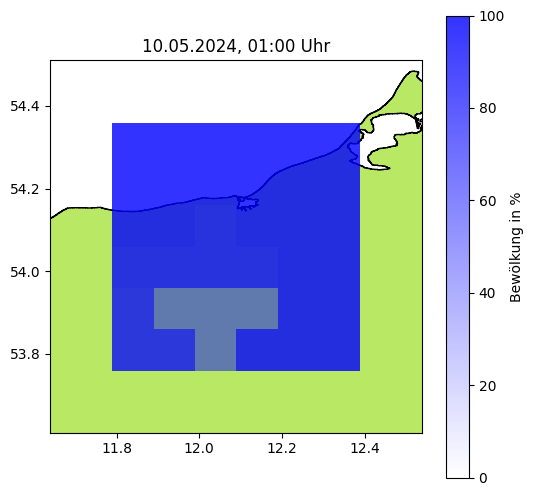

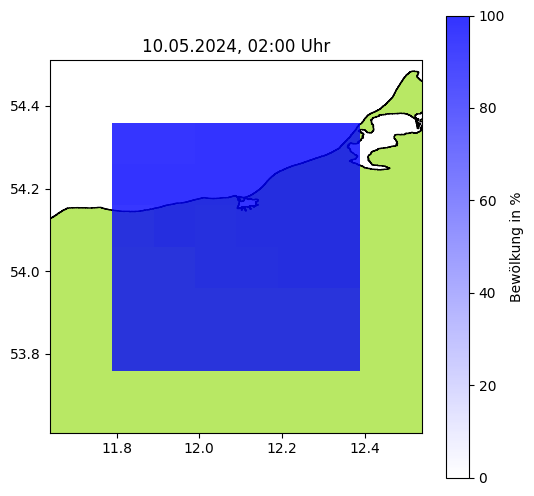

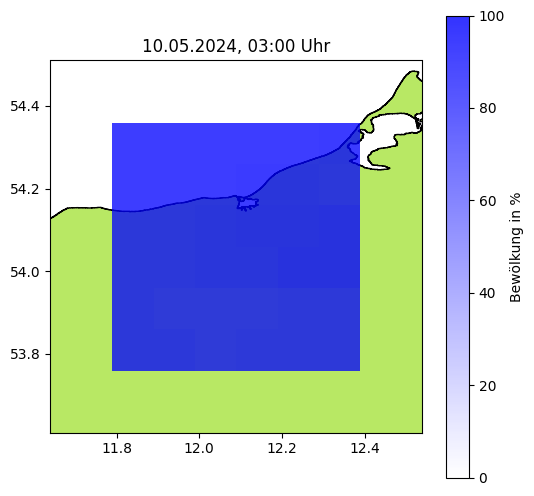

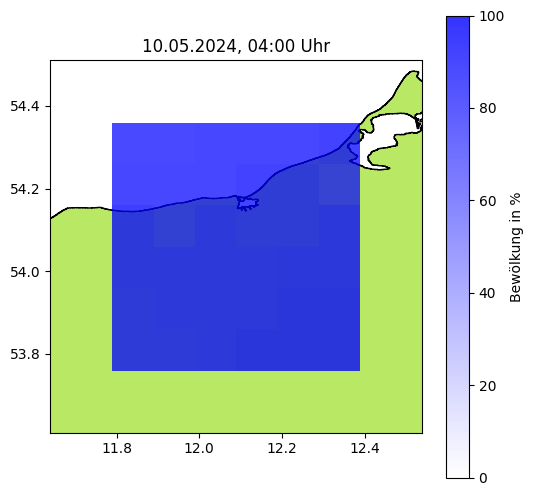

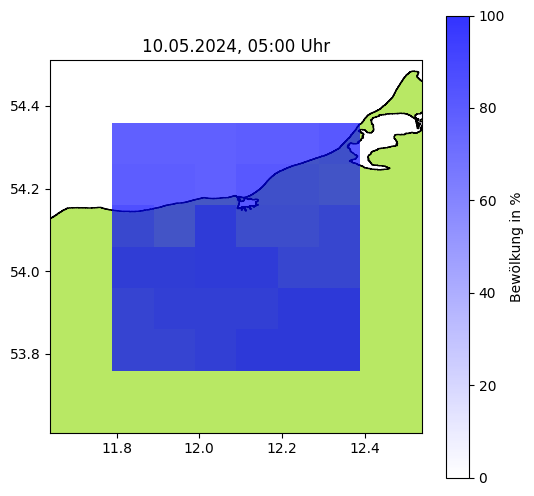

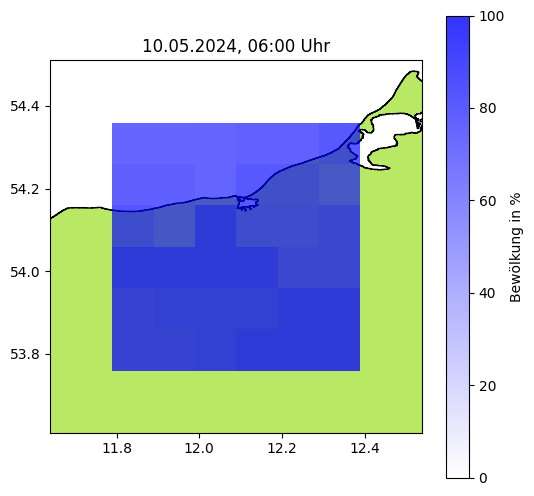

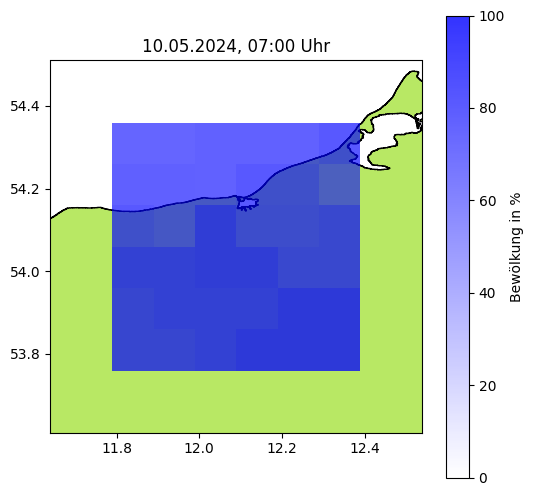

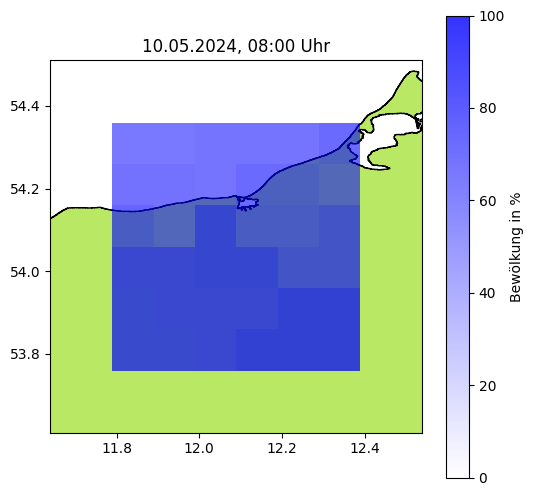

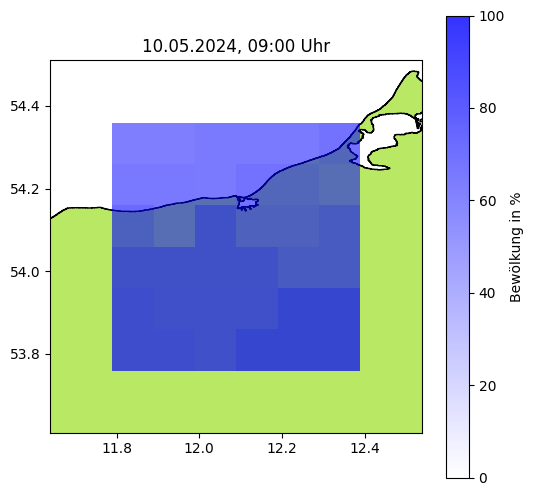

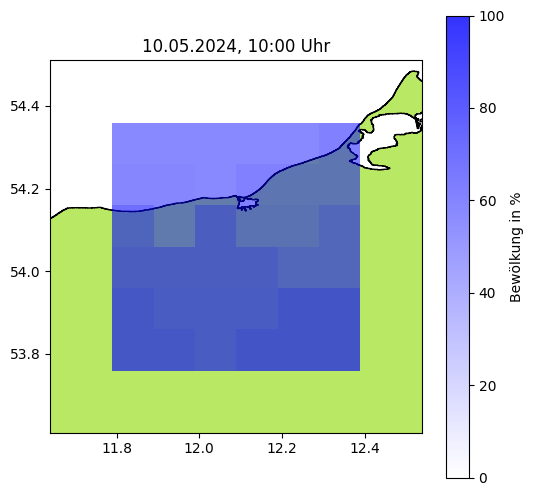

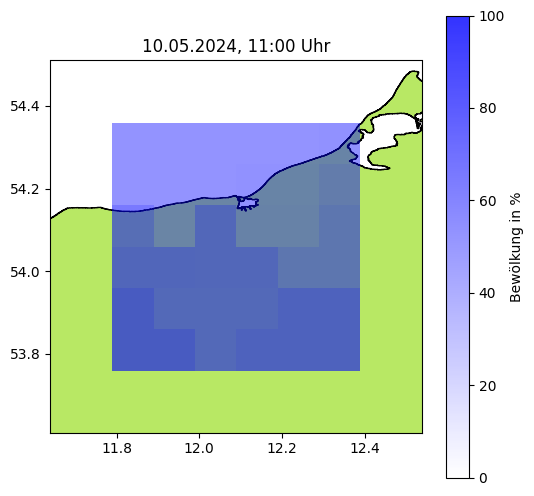

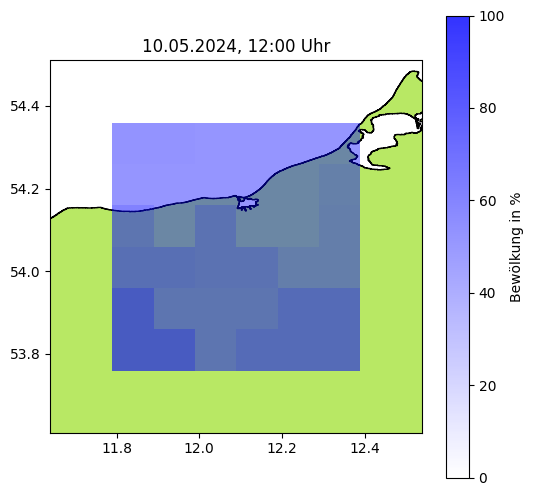

In [4]:
import geopandas
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os


# remove old images
for file in os.listdir('data'):
    if file.startswith('clouds_'):
        os.remove(os.path.join('data', file))


worldmap = geopandas.read_file('./shapefiles/gadm41_DEU_1.shp')

number_of_keys = len(clouds_cover_over_time.keys())
number_of_cols = 3
number_of_rows = number_of_keys // number_of_cols + 1

x_labels = [(lon + ((x - number_of_size_steps // 2) * step_size)) for x in range(number_of_size_steps)]
y_labels = [(lat + ((y - number_of_size_steps // 2) * step_size)) for y in range(number_of_size_steps)]
x_labels = [round(x, 2) for x in x_labels]
y_labels = [round(y, 2) for y in y_labels]
y_labels.reverse()

# fig = plt.figure(figsize=(6 * number_of_cols, 6 * number_of_rows))
colors = [(0, 0, 1, a) for a in np.linspace(0, 0.8, 100)]
cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', colors)

for entry, data in clouds_cover_over_time.items():
    index = list(clouds_cover_over_time.keys()).index(entry)
    
    # ax = fig.add_subplot(number_of_rows, 3, index + 1)
    fig, ax = plt.subplots(figsize=(6, 6))

    worldmap.plot(ax = ax, color='#b8e864', edgecolor='black')

    df = pd.DataFrame(data, columns=x_labels, index=y_labels)

    x = df.columns
    y = df.index
    z = df.values  
    c = ax.pcolormesh(
        x,
        y,
        z,
        cmap=cmap,
        shading='auto',
        vmin=data_retreiver.min_value,
        vmax=data_retreiver.max_value
    )
    start_date_iso = datetime.fromisoformat(entry)

    ax.set_title(start_date_iso.__format__('%d.%m.%Y, %H:%M Uhr'))
    ax.set_ylim(min(y) - 0.2, max(y) + 0.2)
    ax.set_xlim(min(x) - 0.2, max(x) + 0.2)
    fig.colorbar(c, ax=ax, orientation='vertical', label='Bewölkung in %')

    plt.savefig(f'data/clouds_{index}.png', dpi=150, transparent=False, format='png', bbox_inches='tight', pad_inches=0.1)
    
# plt.savefig('clouds_over_time.png', dpi=150, transparent=False, format='png', bbox_inches='tight', pad_inches=0.1)

In [5]:
import PySimpleGUI as sg

layout = [
    [sg.Image(filename=f'data/clouds_0.png', key='forecast_image')],
    [sg.HSeparator()],
    [
        sg.Checkbox('Animation', key='animation_checkbox', default=True),
        sg.Slider((1, number_of_keys), orientation='horizontal', key='index_slider')
    ]
]

window = sg.Window('Clouds over time', layout, finalize=True)

image_index = 0

while True:
    event, values = window.read(timeout=500)

    if event == sg.WIN_CLOSED:
        break

    if event == sg.TIMEOUT_KEY:
        if values['animation_checkbox']:
            window['forecast_image'].update(filename=f'data/clouds_{image_index}.png')
            window['index_slider'].update(value=image_index + 1)

            image_index = (image_index + 1) % number_of_keys
        else:
            image_index = int(values['index_slider'] - 1)
            window['forecast_image'].update(filename=f'data/clouds_{image_index}.png')

    if event == 'index_slider':
        image_index = int(values['index_slider'] - 1)
        window['forecast_image'].update(filename=f'data/clouds_{image_index}.png')

window.close()